# Consistency models

This notebook is a first-pass implementation of OpenAI's [Consistency Models](https://arxiv.org/abs/2303.01469). Disclaimers — a) I have only worked with small datasets so far (fashion MNIST and CIFAR-10), b) I've had better results with consistency distillation than consistency training (Consistency training works much better when you initialise from a pretrained model, but in my mind this rather negates the point), and c) I've not yet explored the continuous time implementation.

In [ ]:
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, seaborn as sns, copy, re
from pathlib import Path
from functools import partial
import fastcore.all as fc
from torch import tensor, nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from datasets import load_dataset
import torchvision.transforms.functional as TF
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from diffusers import UNet2DModel
from accelerate import Accelerator
from fastprogress import progress_bar
import fastcore.all as fc

from miniai.core import *
from miniai.resnet import *
from miniai.datasets import *
from miniai.accel import *
from miniai.learner import *

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

### Karras model

We'll do distillation first, which first means training an EDM model using the method from Karras et al. (2022).

In [ ]:
from karras import noisify_karras, karras_scaler

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
def collate_ddpm(b, **kwargs): return noisify_karras(default_collate(b)['image'], **kwargs)
def dl_ddpm(ds, bs, **kwargs): return DataLoader(ds, batch_size=bs, collate_fn=partial(collate_ddpm, **kwargs), num_workers=4)

In [ ]:
@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b['image']]

name = 'fashion_mnist'
ds = load_dataset(name)
bs = 128
seed = 42
sigma_data = 0.33

tds = ds.with_transform(transform)
dls = DataLoaders(dl_ddpm(tds['train'], bs, sigma_data=sigma_data), dl_ddpm(tds['test'], bs, sigma_data=sigma_data))
(xb_noised, sigma), target = next(iter(dls.train))

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

#### Train

In [ ]:
lr, epochs = 1e-3, 50
steps = len(dls.train)*epochs
scheduler = LRScheduler(partial(lr_scheduler.OneCycleLR, total_steps=steps, max_lr=lr))
model = UNet(in_channels=1, out_channels=1, block_out_channels=(64, 128, 256, 768))
init_ddpm(model)
cbs = [DeviceCB(), ProgressCB(plot=True), MixedPrecisionCB(), MetricsCB()]
learn = Learner(dls, model, cbs=cbs, scheduler=scheduler, loss_func=nn.MSELoss(), opt_func=partial(optim.AdamW, eps=1e-5))

loss,epoch,train
0.523,0,train
0.259,0,eval
0.209,1,train
0.188,1,eval
0.181,2,train
0.175,2,eval
0.170,3,train
0.166,3,eval
0.164,4,train
0.164,4,eval


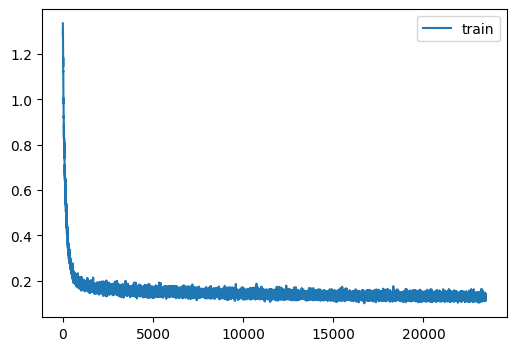

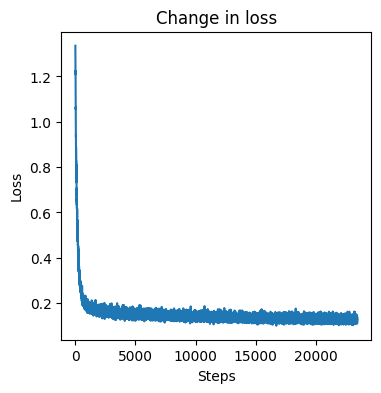

In [ ]:
learn.fit(lr, epochs)

In [ ]:
# torch.save(learn.model, '/home/models/karras_big_50.pkl')

#### Sample

In [ ]:
model = torch.load('/home/models/karras_big_50.pkl')

In [ ]:
from sample import karras_sample, heun

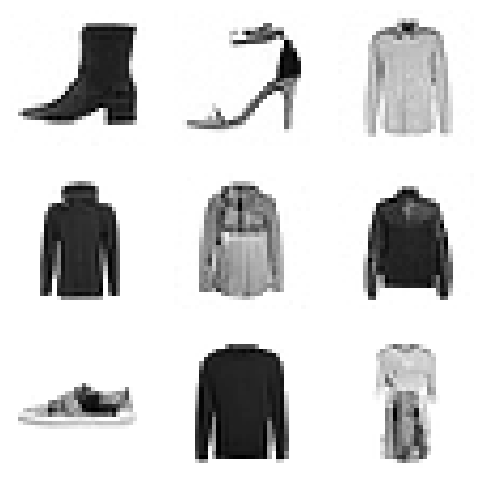

In [ ]:
samples = karras_sample(heun, (2048,1,32,32), model, steps=50, sigma_data=0.33)
show_images((samples[:9]+0.5).clip(0,1), imsize=2)

FID will give us a sense of how the consistency model performs in comparison. All the normal caveats to FID apply.

In [ ]:
from miniai.fid import FID

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
bs = 2048
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
class_model = torch.load('/home/models/resnet_dataaug_20_2.pkl')
fidder = FID(dls, class_model, 5)

The FID score for the dataset itself is:

In [ ]:
xb, yb = next(iter(dls.train))
fidder.fid(xb)

1.56134033203125

The FID score for the samples is:

In [ ]:
fidder.fid(samples+0.5)

2.031341552734375

So, this is about the best model we could train on this dataset (it wouldn't be worth training anything bigger), which should make it a good teacher for distillation.

### Consistency distillation

Now that we have a model to distil, let's build a consistency model to reduce the number of sampling steps. The Karras model above will act as the teacher, and the consistency setup aims to build mappings between points along its solution trajectories that allow for faster sampling.

In [ ]:
from consistency import ConsistencyCB
from loss import LPIPS
from model import ConsistencyModel

A pretrained VGG network for the LPIPS perceptual loss.

In [ ]:
import timm

vgg = timm.create_model('vgg16', pretrained=True).features.to('cuda:1')

The `ConsistencyModel` will be the online model. The `ConsistencyModel` and `UNet` architectures are exactly the same, and the `ConsistencyModel`'s weights will be initialised from the teacher model. The only difference is in the scaling of the data — the `ConsistencyModel` wraps the normal `UNet2DModel` object with the `consistency_scaler` function instead of the `karras_scaler`.

In [ ]:
model = ConsistencyModel(in_channels=1, out_channels=1, block_out_channels=(64, 128, 256, 768))
teacher_model = torch.load('/home/models/karras_big_50.pkl')

Since `sigma` is dependent on `n`, I'm doing the image noisification as part of the training loop, rather than in the dataloader as before (it's simpler). Note that it's important to load the data into the same distribution as was used for the original teacher model, which in this case is a distribution from -0.5 -> 0.5. I had several failed attempts before I realised that the distribution was affecting the samples.

#### Train

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
# change batch size if you're working with a small GPU - there are up to 4 models in memory at one time (teacher, online, online_ema, vgg)
# this fits on one 48GB GPU
bs = 96
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
lr, epochs = 4e-5, 20
steps = epochs*len(dls.train)
scheduler = LRScheduler(partial(lr_scheduler.OneCycleLR, total_steps=steps, max_lr=lr))
consistency = ConsistencyCB(training_mode='distillation', teacher_model=teacher_model, use_ema=True, mu0=0.9, sigma_data=0.33, device='cuda:1')
cbs = [DeviceCB(device='cuda:1'), MetricsCB(), ProgressCB(plot=True), consistency]
loss = LPIPS(vgg, device='cuda:1')
learn = Learner(dls, model, cbs=cbs, scheduler=scheduler, loss_func=loss, opt_func=partial(optim.Adam, eps=1e-5))

As a quick overview, we are going to:

1. Noisify the images
2. Distil the teacher model
3. Measure the loss via the online model
4. Maintain an EMA of the online model (the model we actually want)

loss,epoch,train
3.723,0,train
2.125,0,eval
1.731,1,train
1.504,1,eval
1.305,2,train
1.165,2,eval
1.077,3,train
0.975,3,eval
0.902,4,train
0.851,4,eval


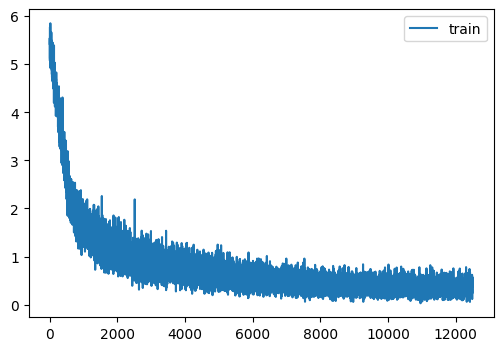

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



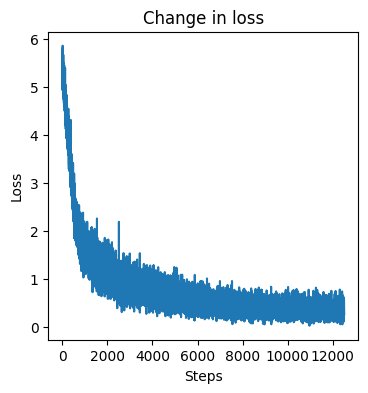

In [ ]:
learn.fit(lr, epochs)

#### Sample

In [ ]:
from sample import consistency_sample, karras_sample, heun
from karras import sigmas_karras

In [ ]:
@torch.no_grad()
def consistency_sample(size, model, steps=100, device='cuda', sigma_min=2e-3, sigma_max=80., sigma_data=0.):
    x = torch.randn(size).to(device) * sigma_max
    sigma = sigmas_karras(steps).to(device)
    x = model((x, torch.tensor(sigma_max)), sigma_data=sigma_data)
    if steps <= 1: return x
    for t in progress_bar(range(steps-1)):
        z = torch.randn_like(x)
        xt = x + (sigma[t]**2 - sigma_min**2).sqrt()*z
        x = model((xt, (sigma[t]**2 - sigma_min**2).sqrt()), sigma_data=sigma_data)
    return x

Below we can recover reasonable samples from the consistency model after about 20 steps.

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
bs = 2048
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from miniai.fid import FID
class_model = torch.load('/home/models/resnet_dataaug_20_2.pkl')
fidder = FID(dls, class_model, 5)

In [ ]:
consistency_model = torch.load('/home/models/consistency_big_50.pkl')

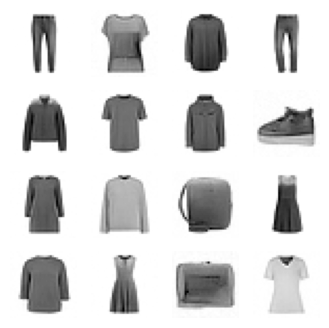

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=20, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

10.352325439453125

Those samples aren't bad. They are however not as good as the original model over the same number of steps, as we can see below. Some of the finer details are missing and they look 'smoother', while the colour distribution looks marginally lighter.

In [ ]:
karras_model = torch.load('/home/models/karras_big_50.pkl').to('cuda:1')

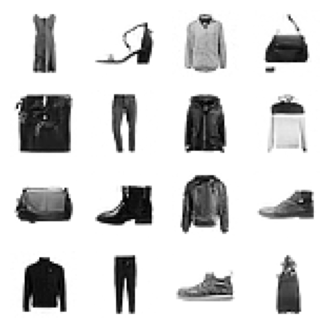

In [ ]:
samples = karras_sample(heun, (2048,1,32,32), karras_model, steps=20, sigma_data=0.33, device='cuda:1')
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

2.102508544921875

What about over 10 steps?

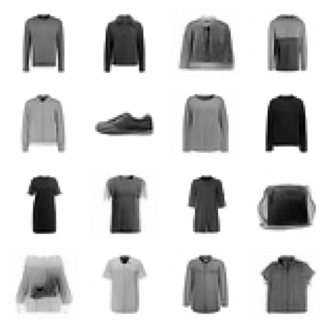

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=10, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

14.178131103515625

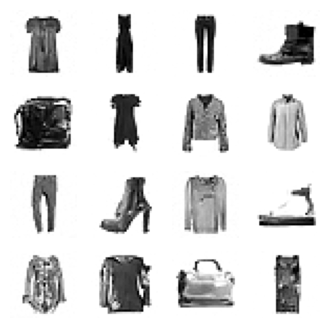

In [ ]:
samples = karras_sample(heun, (2048,1,32,32), karras_model, steps=10, sigma_data=0.33, device='cuda:1')
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

2.381072998046875

What about over 5 steps?

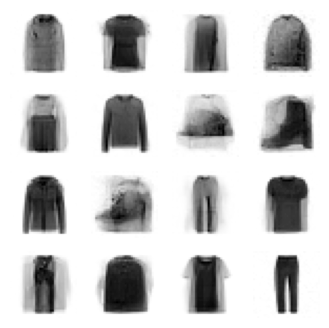

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=5, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

25.471282958984375

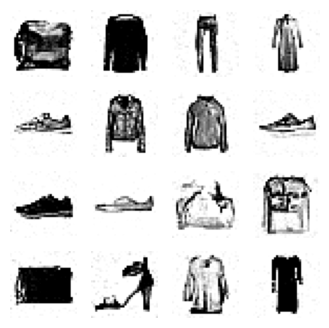

In [ ]:
samples = karras_sample(heun, (2048,1,32,32), karras_model, steps=5, sigma_data=0.33, device='cuda:1')
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

16.44769287109375

The original model starts to fail around here, and I suspect this would be even more apparent for more complex images. The consistency model has smoother images in some sense, but is also struggling to make a decision about which garment to choose, leading to superimposed garments.

How about 2 steps?

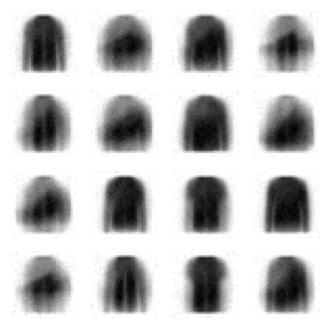

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=2, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

58.174530029296875

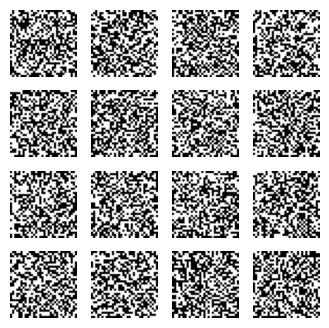

In [ ]:
samples = karras_sample(heun, (2048,1,32,32), karras_model, steps=2, sigma_data=0.33, device='cuda:1')
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

2131.1572265625

The original model is now completely useless. In terms of FID, the consistency model performs much better (which is a useful data point), but the images themselves are obviously terrible. As is always the case with research papers, I suspect it will take a lot more experimentation to get this to work well.

### Longer training

I only trained the consistency model for 20 epochs, and it may benefit from a longer training cycle.

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
# change batch size if you're working with a small GPU - there are up to 4 models in memory at one time (teacher, online, online_ema, vgg)
# this fits on one 48GB GPU
bs = 96
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model = ConsistencyModel(in_channels=1, out_channels=1, block_out_channels=(64, 128, 256, 768))
teacher_model = torch.load('/home/models/karras_big_50.pkl')

In [ ]:
lr, epochs = 4e-5, 40
steps = epochs*len(dls.train)
scheduler = LRScheduler(partial(lr_scheduler.OneCycleLR, total_steps=steps, max_lr=lr))
consistency = ConsistencyCB(training_mode='distillation', teacher_model=teacher_model, use_ema=True, mu0=0.9, sigma_data=0.33, device='cuda:1')
cbs = [DeviceCB(device='cuda:1'), MetricsCB(), ProgressCB(plot=True), consistency]
loss = LPIPS(vgg, device='cuda:1')
learn = Learner(dls, model, cbs=cbs, scheduler=scheduler, loss_func=loss, opt_func=partial(optim.Adam, eps=1e-5))

loss,epoch,train
3.900,0,train
2.498,0,eval
2.004,1,train
1.743,1,eval
1.554,2,train
1.416,2,eval
1.309,3,train
1.214,3,eval
1.130,4,train
1.075,4,eval


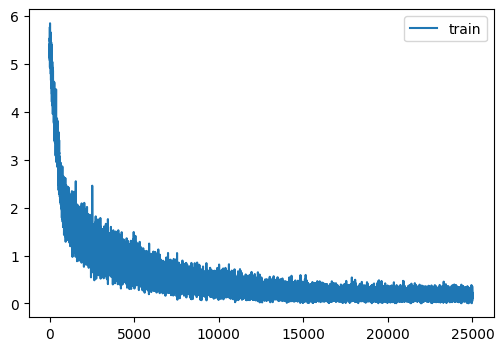

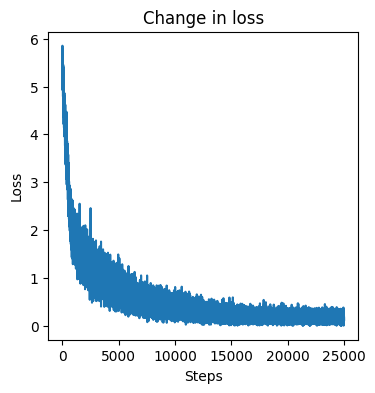

In [ ]:
learn.fit(lr, epochs)

#### Sample

In [ ]:
name = 'fashion_mnist'
ds = load_dataset(name)
bs = 2048
seed = 42

@inplace
def transform(b): b['image'] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b['image']]

tds = ds.with_transform(transform)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Found cached dataset fashion_mnist (/home/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from miniai.fid import FID
class_model = torch.load('/home/models/resnet_dataaug_20_2.pkl')
fidder = FID(dls, class_model, 5)

In [ ]:
consistency_model = torch.load('/home/models/consistency_big_50_long.pkl')

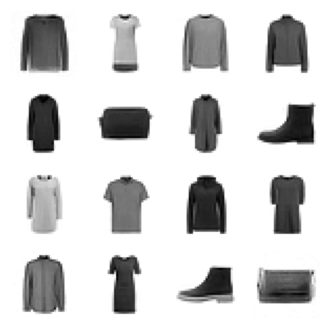

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=20, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

10.60198974609375

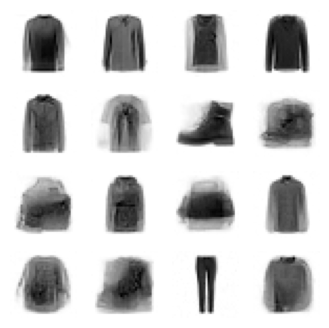

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=5, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)

In [ ]:
fidder.fid(samples+0.5)

26.467987060546875

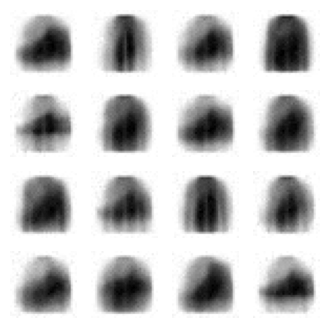

In [ ]:
samples = consistency_sample((2048,1,32,32), consistency_model, steps=2, device='cuda:1', sigma_data=0.33)
show_images((samples[:16]+0.5).clip(0,1), imsize=1)